In [1]:
"""
    helm.model_dkps_analysis
"""

import argparse
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from rich import print as rprint

# --
# CLI

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--dataset',   type=str, default='math:subject=intermediate_algebra')
    parser.add_argument('--score_col', type=str, default='score')
    parser.add_argument('--outdir',    type=str, default='results')
    args = parser.parse_args()
    
    args.tsv_path = Path(args.outdir) / f'{args.dataset}-{args.score_col}-res.tsv'
    args.plot_dir = Path('plots') / args.dataset.replace(':', '-')
    
    args.plot_dir.mkdir(parents=True, exist_ok=True)
        
    return args


dataset = 'math:subject=intermediate_algebra'
score_col = 'score'
outdir = '/home/user/helivan-project-generation/ep-dkps-results/results'
plot_dir=Path('plots') / dataset.replace(':', '-')
tsv_path = Path(outdir) / f'{dataset}-{score_col}-res.tsv'
plot_dir.mkdir(parents=True, exist_ok=True)


# --
# IO

df_res = pd.read_csv(tsv_path, sep='\t')
model_names  = df_res.target_model.unique()
n_replicates = df_res.seed.nunique()

# alias the run with all models
df_res['p_lr_dkps8'] = df_res['p_lr_dkps8__n_components_cmds=8__n_models=ALL']

# compute interpolation
max_samples        = df_res.n_samples.max()
df_res['p_interp'] = (df_res.n_samples * df_res.p_sample + (max_samples - df_res.n_samples) * df_res.p_lr_dkps8) / max_samples
df_res['e_interp'] = np.abs(df_res.p_interp - df_res.y_act)

if any([xx in dataset for xx in ['med_qa', 'legalbench']]):
    df_res = df_res[df_res.n_samples > 2]

# --
# Plot gain (average per model)

gain_model = df_res.groupby(['n_samples', 'target_model']).apply(lambda x: (x.e_sample - x.e_interp).mean()).reset_index(name='gain')

for target_model in gain_model.target_model.unique():
    sub = gain_model[gain_model.target_model == target_model]
    _ = plt.scatter(sub.n_samples * np.random.uniform(0.9, 1.1), sub.gain, label=target_model, alpha=0.05, c='black')

_ = plt.axhline(0, c='black')
_ = plt.grid('both', alpha=0.25, c='gray')
_ = plt.xscale('log')
_ = plt.ylabel('err_sample - err_interp')
_ = plt.xlabel('Number of queries (m)')
_ = plt.title(f'{dataset} \n Performance gain (average per model)')
_ = plt.tight_layout()
_ = plt.savefig(plot_dir / f'{score_col}-err-bymodel.png')
_ = plt.close()

# --
# Plot gain (per replicate)

for target_model in df_res.target_model.unique():
    sub = df_res[df_res.target_model == target_model]
    _ = plt.scatter(sub.n_samples * np.random.uniform(0.9, 1.1), sub.e_sample - sub.e_interp, label=target_model, alpha=0.05, c='black', s=2)

_ = plt.axhline(0, c='black')
_ = plt.grid('both', alpha=0.25, c='gray')
_ = plt.xscale('log')
_ = plt.ylabel('err_sample - err_interp')
_ = plt.xlabel('Number of queries (m)')
_ = plt.title(f'{dataset} \n Performance gain (per replicate)')
_ = plt.tight_layout()
_ = plt.savefig(plot_dir / f'{score_col}-err-byreplicate.png')
_ = plt.close()

# --
# Plot error vs number of queries

_cols = [
    {
        "colname"   : "e_null",
        "label"     : "Population Mean",
        "c"         : "black",
        "linestyle" : "-",
        "plots"     : [0, 1],
    },
    {
        "colname"   : "e_sample",
        "label"     : "Sample Mean",
        "c"         : "green",
        "linestyle" : "-",
        "plots"     : [0, 1],
    },
    {
        "colname"   : "e_lr_dkps8__n_components_cmds=8__n_models=20",
        "label"     : "DKPS(d=8, n_models=20)",
        "c"         : "red",
        "linestyle" : ":",
        "plots"     : [0],
    },
    {
        "colname"   : "e_lr_dkps8__n_components_cmds=8__n_models=50",
        "label"     : "DKPS(d=8, n_models=50)",
        "c"         : "red",
        "linestyle" : "--",
        "plots"     : [0],
    },
    {
        "colname"   : "e_lr_dkps8__n_components_cmds=8__n_models=ALL",
        "label"     : "DKPS(d=8, n_models=ALL)",
        "c"         : "red",
        "linestyle" : "-",
        "plots"     : [0, 1],
    },
    {
        "colname"   : "e_interp",
        "label"     : "interp(e_sample+e_lr_dkps8)",
        "c"         : "blue",
        "linestyle" : "-",
        "plots"     : [1],
    },
]
    
df_avg = df_res.groupby(['mode', 'n_samples']).agg({
    'y_act' : lambda x: np.mean(x),
    **{c['colname']: lambda x: np.mean(x) for c in _cols},
}).reset_index()

# 0th version
for c in _cols:
    if 0 not in c['plots']: continue
    _ = plt.plot(df_avg.n_samples, df_avg[c['colname']], label=c['label'], c=c['c'], linestyle=c['linestyle'], lw=2)

_ = plt.legend()
_ = plt.grid('both', alpha=0.25, c='gray')
_ = plt.xscale('log')
_ = plt.ylabel(r'$MAE(\hat{y}, y)$')
_ = plt.xlabel('Number of queries (m)')
_ = plt.title(f'{dataset}')

_ = plt.tight_layout()
_ = plt.savefig(plot_dir / f'{score_col}-err-simple-0.png')
_ = plt.close()


# 1st version
for c in _cols:
    if 1 not in c['plots']: continue
    _ = plt.plot(df_avg.n_samples, df_avg[c['colname']], label=c['label'], c=c['c'], linestyle=c['linestyle'], lw=2)

_ = plt.legend()
_ = plt.grid('both', alpha=0.25, c='gray')
_ = plt.xscale('log')
_ = plt.ylabel('$MAE(\hat{y}, y)$')
_ = plt.xlabel('Number of queries (m)')
_ = plt.title(f'{dataset}')

_ = plt.tight_layout()
_ = plt.savefig(plot_dir / f'{score_col}-err-simple-1.png')
_ = plt.close()

<>:170: SyntaxWarning: invalid escape sequence '\h'
<>:170: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_1498632/221340268.py:170: SyntaxWarning: invalid escape sequence '\h'
  _ = plt.ylabel('$MAE(\hat{y}, y)$')
/tmp/ipykernel_1498632/221340268.py:59: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gain_model = df_res.groupby(['n_samples', 'target_model']).apply(lambda x: (x.e_sample - x.e_interp).mean()).reset_index(name='gain')


legalbench:subset=abercrombie-score-res.tsv


clipping DKPS columns to (0, 1) - ['p_null', 'p_sample', 'p_lr_dkps8__n_components_cmds=8__n_models=20', 
'p_lr_dkps8__n_components_cmds=8__n_models=50', 'p_lr_dkps8__n_components_cmds=8__n_models=ALL', 'p_lr_dkps8', 
'p_interp']

0 legalbench:subset=abercrombie
med_qa-score-res.tsv


clipping DKPS columns to (0, 1) - ['p_null', 'p_sample', 'p_lr_dkps8__n_components_cmds=8__n_models=20', 
'p_lr_dkps8__n_components_cmds=8__n_models=50', 'p_lr_dkps8__n_components_cmds=8__n_models=ALL', 'p_lr_dkps8', 
'p_interp']

1 med_qa
math:subject=counting_and_probability-score-res.tsv


clipping DKPS columns to (0, 1) - ['p_null', 'p_sample', 'p_lr_dkps8__n_components_cmds=8__n_models=20', 
'p_lr_dkps8__n_components_cmds=8__n_models=50', 'p_lr_dkps8__n_components_cmds=8__n_models=ALL', 'p_lr_dkps8', 
'p_interp']

3 math:subject=counting_and_probability
wmt_14:language_pair=ru-en-meteor-res.tsv


clipping DKPS columns to (0, 1) - ['p_null', 'p_sample', 'p_lr_dkps8__n_components_cmds=8__n_models=20', 
'p_lr_dkps8__n_components_cmds=8__n_models=50', 'p_lr_dkps8__n_components_cmds=8__n_models=ALL', 'p_lr_dkps8', 
'p_interp']

2 wmt_14:language_pair=ru-en-meteor-res


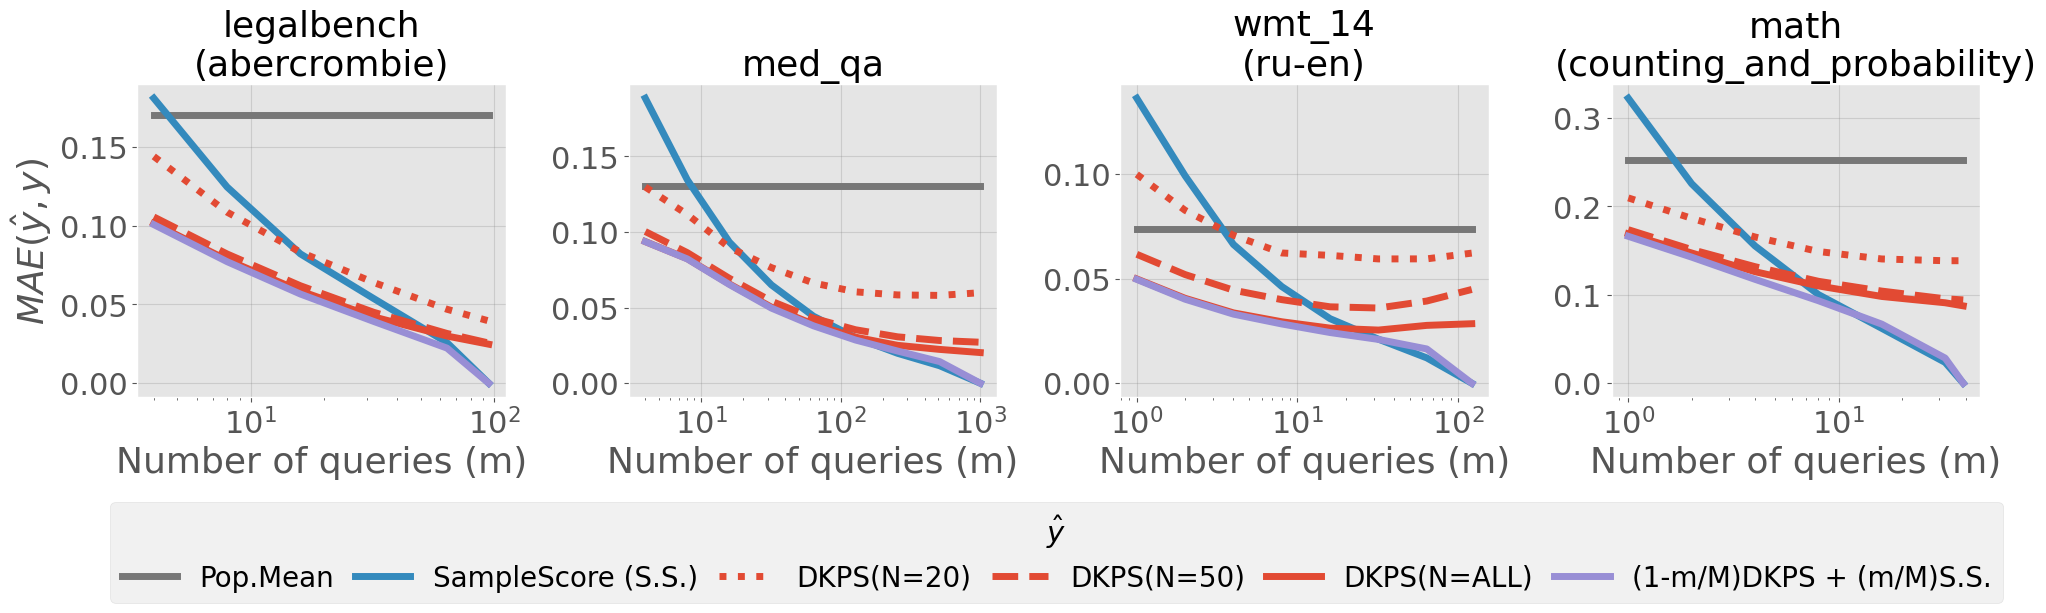

In [3]:
import os
plt.style.use('ggplot')

os.listdir('results/')
score_col = 'score'
outdir = '/home/user/helivan-project-generation/ep-dkps-results/results/'
plot_dir=Path('plots') / dataset.replace(':', '-')
tsv_path = Path(outdir) / f'{dataset}-{score_col}-res.tsv'

fontsize=26
labelsize=22

keep_list = ['legalbench:subset=abercrombie', 'med_qa', 'wmt_14:language_pair=ru-en-meteor-res', 'math:subject=counting_and_probability']
method_label_dict = {
    'Sample Mean': 'SampleScore (S.S.)',
    'Population Mean': 'Pop.Mean',
    'DKPS(d=8, n_models=20)': 'DKPS(N=20)',
    'DKPS(d=8, n_models=50)': 'DKPS(N=50)',
    'DKPS(d=8, n_models=ALL)': 'DKPS(N=ALL)',
    'interp(e_sample+e_lr_dkps8)': '(1-m/M)DKPS + (m/M)S.S.'
}

color_dict = {
    'Sample Mean': list(plt.rcParams['axes.prop_cycle'])[1]['color'],
    'Population Mean': list(plt.rcParams['axes.prop_cycle'])[3]['color'],
    'DKPS(d=8, n_models=20)': list(plt.rcParams['axes.prop_cycle'])[0]['color'],
    'DKPS(d=8, n_models=50)': list(plt.rcParams['axes.prop_cycle'])[0]['color'],
    'DKPS(d=8, n_models=ALL)': list(plt.rcParams['axes.prop_cycle'])[0]['color'],
    'interp(e_sample+e_lr_dkps8)': list(plt.rcParams['axes.prop_cycle'])[2]['color']
}


fig, axs = plt.subplots(1,4, figsize=(20,5))
for file in os.listdir('/home/user/helivan-project-generation/ep-dkps-results/results/'):
    if file[0] == '.':
        continue
    if file[-3:] != 'tsv':
        continue

    _keep = False
    for i, keep in enumerate(keep_list):
        if keep in file:
            _keep = True
            break

    if not _keep:
        continue
    print(file)

    dataset = file.split('-score-res')[0]
    dataset = dataset.split('-meteor-res')[0]
    plot_dir=Path('plots') / dataset.replace(':', '-')
    tsv_path = outdir + file

    df_res = pd.read_csv(tsv_path, sep='\t')
    model_names  = df_res.target_model.unique()
    n_replicates = df_res.seed.nunique()
    
    # alias the run with all models
    df_res['p_lr_dkps8'] = df_res['p_lr_dkps8__n_components_cmds=8__n_models=ALL']
    
    # compute interpolation
    max_samples        = df_res.n_samples.max()
    df_res['p_interp'] = (df_res.n_samples * df_res.p_sample + (max_samples - df_res.n_samples) * df_res.p_lr_dkps8) / max_samples
    df_res['e_interp'] = np.abs(df_res.p_interp - df_res.y_act)

    dkps_cols = [c for c in df_res.columns if 'p_' in c]
    rprint(f'[yellow]clipping DKPS columns to (0, 1) - {dkps_cols}[/yellow]')
    for c in dkps_cols:
        df_res[c] = df_res[c].clip(0, 1)

    for c in dkps_cols:
        df_res[c.replace('p_', 'e_')] = np.abs(df_res[c] - df_res.y_act)
    
    if any([xx in dataset for xx in ['med_qa', 'legalbench']]):
        df_res = df_res[df_res.n_samples > 2]


    df_avg = df_res.groupby(['mode', 'n_samples']).agg({
        'y_act' : lambda x: np.mean(x),
        **{c['colname']: lambda x: np.mean(x) for c in _cols},
    }).reset_index()

    print(i, keep)
    ax = axs[i]
    
    # 0th version
    for c in _cols:
        # if 1 not in c['plots']: continue
        method_label = method_label_dict[c['label']]
        if 'm/M' in method_label:
            color='brown'
        else:
            color=c['c']
        color=color_dict[c['label']]
        ax.plot(df_avg.n_samples, df_avg[c['colname']], label=method_label, c=color, linestyle=c['linestyle'], lw=5)
    
    # _ = ax.legend()
    ax.grid('both', alpha=0.25, c='gray')
    ax.set_xscale('log')
    ax.set_xlabel('Number of queries (m)', fontsize=fontsize)
    title=dataset.replace(':', '\n')
    if '=' in title:
        title = title.split('\n')[0] + '\n' + f'({title.split('\n')[-1].split('=')[-1]})'
    ax.set_title(f'{title}', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)


axs[0].set_ylabel(r'$MAE(\hat{y}, y)$', fontsize=fontsize)
plt.tight_layout()
axs[0].legend(loc='lower left', columnspacing=0.75, bbox_to_anchor=(-0.11,-0.7), ncols=6, fontsize=labelsize-2, title=r'$\hat{y}$', title_fontsize=labelsize-1, framealpha=0.5)

# plt.savefig('figures/fig2.pdf', bbox_inches='tight')